In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # n-gram
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
file_path = './../../Fed1_dataset/Interest_rate_prediction.csv'

# FED_ir의 의미 : FED interest rate
df_irp = pd.read_csv(file_path)

df_irp.head()

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,BB_text,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM
0,2008-12-01,0.25,0.0,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,2.50,Prepared at the Federal Reserve Bank of Minnea...,0.080,0.839,0.082,0.9133,2008-12
1,2009-01-01,0.25,0.0,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-01
2,2009-02-01,0.25,0.0,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-02
3,2009-03-01,0.25,0.0,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,1.50,Prepared at the Federal Reserve Bank of San Fr...,0.083,0.839,0.078,0.5459,2009-03
4,2009-04-01,0.25,0.0,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,1.25,Prepared at the Federal Reserve Bank of Dallas...,0.092,0.826,0.082,-0.6999,2009-04


전처리

In [6]:
df_irp['DATE'] = pd.to_datetime(df_irp['DATE']) # 날짤형으로 변환

In [8]:
df_irp.dtypes

DATE            datetime64[ns]
DFEDTARU               float64
DFEDTARL               float64
IR_FORCAST             float64
GDPGR                  float64
UNRATE                 float64
PCEPI                  float64
TNX                    float64
USD                    float64
KR_IR                  float64
ECB_IR                 float64
BB_text                 object
BB_neg                 float64
BB_neu                 float64
BB_pos                 float64
BB_sentiment           float64
DATE_YM                 object
dtype: object

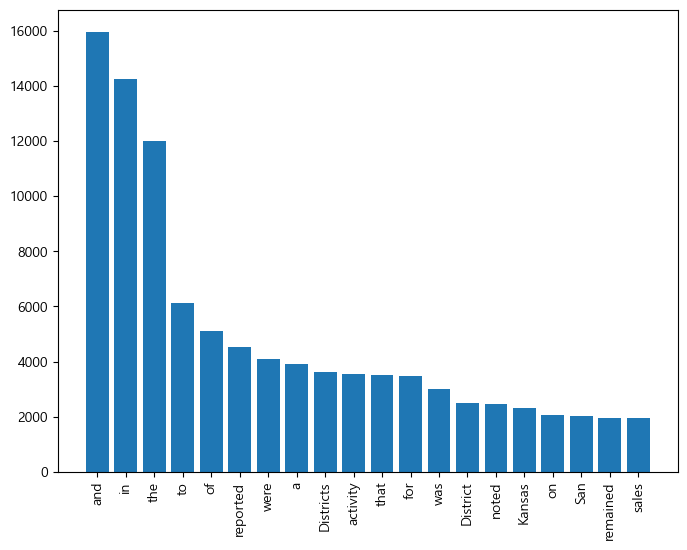

In [10]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

In [11]:
df_irp['BB_text'] = df_irp['BB_text'].str.lower()  # 소문자로
df_irp['BB_text'] = df_irp['BB_text'].str.strip()  # 앞뒤 공백 제거
df_irp['BB_text'] = df_irp['BB_text'].str.replace('\s+', ' ', regex=True)  # 중간 공백 제거
# 숫자, 대문자, 소문자 알파벳 및 공백을 제외한 모든 문자 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [14]:
# 불용어 제거
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_irp['BB_text'] = df_irp['BB_text'].apply(remove_stopwords)

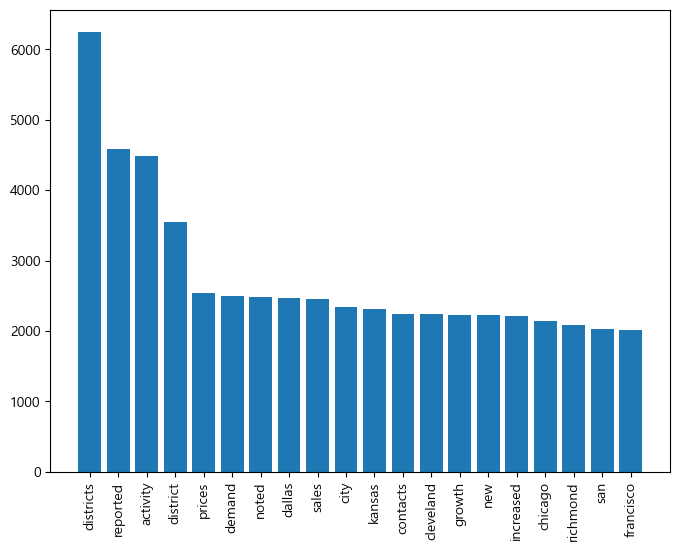

In [16]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

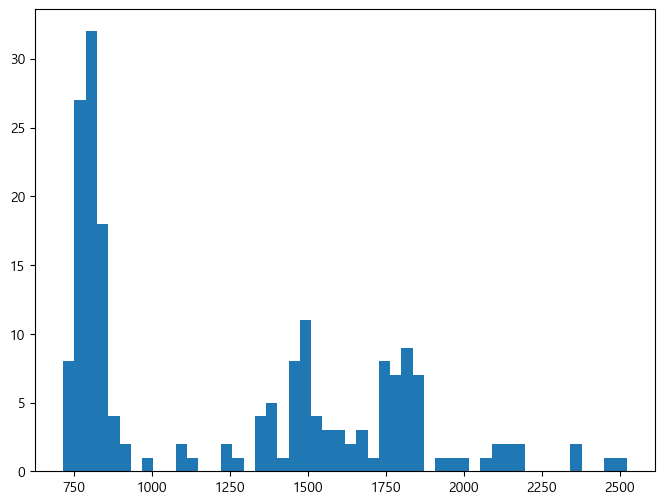

In [18]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

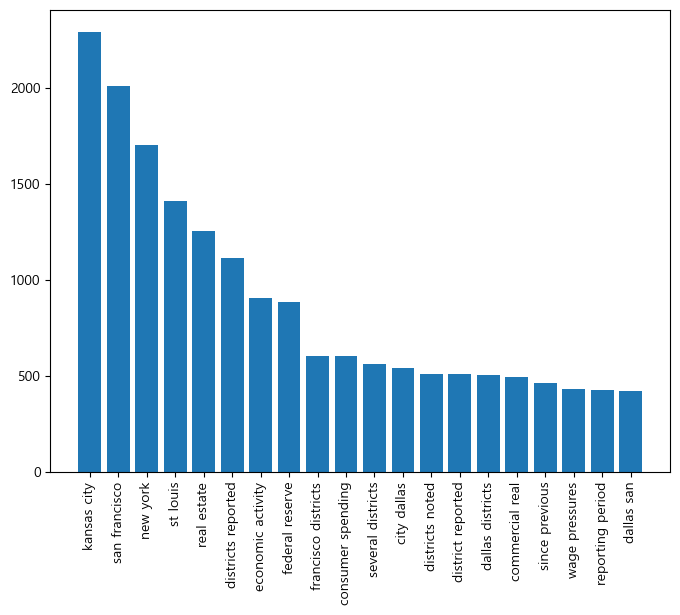

In [20]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

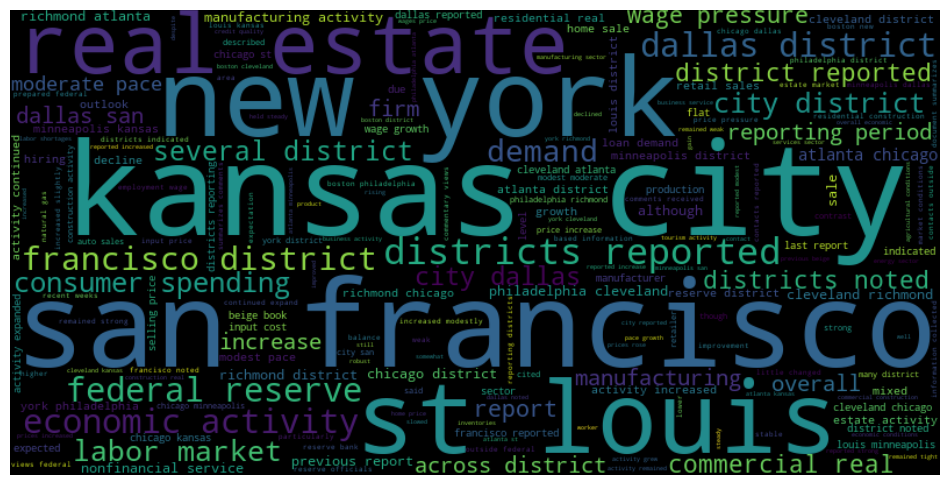

In [21]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
# 연방준비은행 지역 목록 제거st louis와 같은 경우도 감안
federal_reserve_banks = [
    "boston", 
    "new york", 
    "philadelphia", 
    "cleveland", 
    "richmond", 
    "atlanta", 
    "chicago", 
    "st. louis", 
    "minneapolis", 
    "kansas city", 
    "dallas", 
    "san francisco",
    "st",
    "louis"
]

# 연방준비은행 지역 필터링 함수
def remove_federal_reserve_banks(text, bank_list):
    # 소문자 변환 및 정규표현식을 사용하여 지역 이름 제거
    for bank in bank_list:
        bank_pattern = re.compile(re.escape(bank), re.IGNORECASE)
        text = bank_pattern.sub('', text)
    return text

# 연방준비은행 지역 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: remove_federal_reserve_banks(x, federal_reserve_banks))

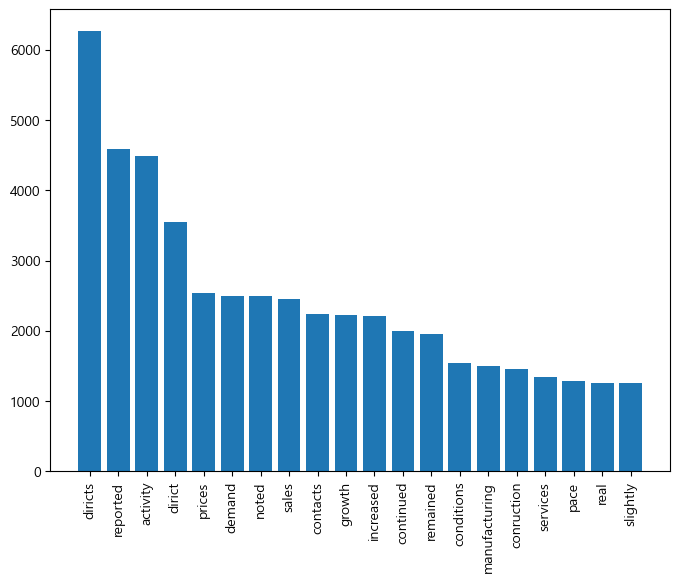

In [24]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

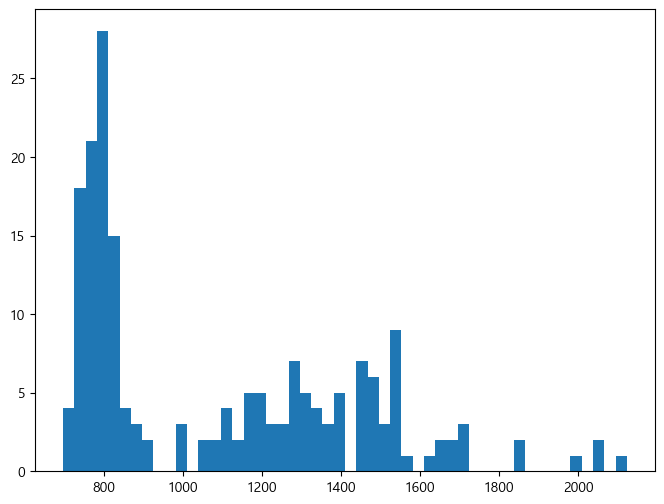

In [26]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

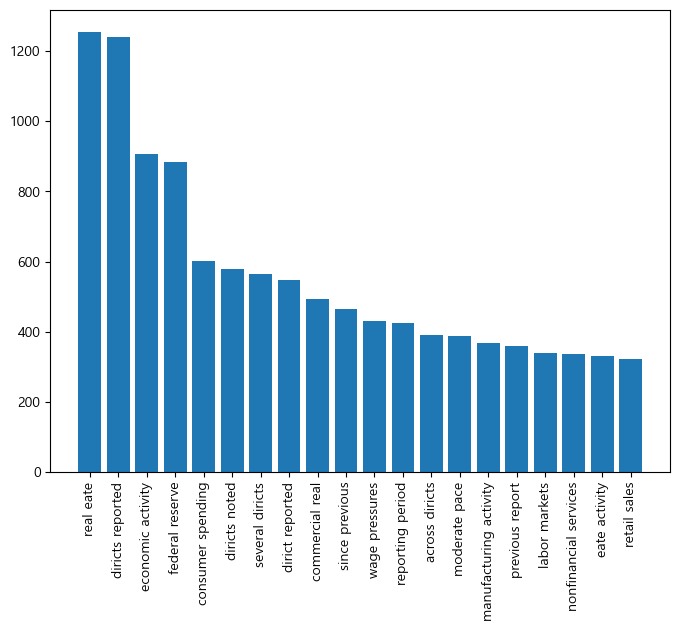

In [29]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

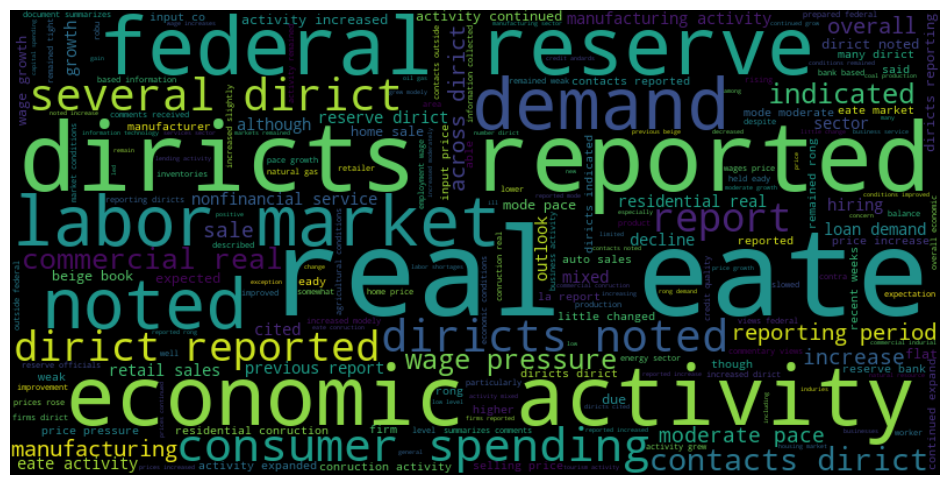

In [32]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

감정분석 : 전처리 이전과 이후 비교

In [35]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dybae\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [36]:
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']

df_irp[['f_neg', 'f_neu', 'f_pos', 'f_sentiment']] = df_irp['BB_text'].apply(lambda text: pd.Series(get_vader_sentiment(text)))

df_irp

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,...,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM,text_length,f_neg,f_neu,f_pos,f_sentiment
0,2008-12-01,0.25,0.00,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,...,0.080,0.839,0.082,0.9133,2008-12,916,0.111,0.804,0.085,-0.9594
1,2009-01-01,0.25,0.00,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,...,0.061,0.865,0.074,0.9952,2009-01,1451,0.109,0.787,0.103,-0.6317
2,2009-02-01,0.25,0.00,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,...,0.061,0.865,0.074,0.9952,2009-02,1451,0.109,0.787,0.103,-0.6317
3,2009-03-01,0.25,0.00,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,...,0.083,0.839,0.078,0.5459,2009-03,1376,0.116,0.786,0.098,-0.8791
4,2009-04-01,0.25,0.00,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,...,0.092,0.826,0.082,-0.6999,2009-04,1295,0.124,0.779,0.097,-0.9705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2024-03-01,5.50,5.25,5.50,1.4,3.8,122.782,4.206,1347.2,3.5,...,0.056,0.797,0.147,0.9991,2024-03,824,0.067,0.793,0.141,0.9966
184,2024-04-01,5.50,5.25,5.50,2.8,3.9,123.109,4.686,1382.0,3.5,...,0.068,0.807,0.126,0.9974,2024-04,790,0.071,0.813,0.117,0.9886
185,2024-05-01,5.50,5.25,5.50,2.8,4.0,123.146,4.514,1384.5,3.5,...,0.076,0.783,0.141,0.9982,2024-05,817,0.072,0.794,0.135,0.9953
186,2024-06-01,5.50,5.25,5.50,2.8,4.1,123.243,4.343,1376.7,3.5,...,0.076,0.783,0.141,0.9982,2024-06,817,0.072,0.794,0.135,0.9953


RNN

In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [41]:
df_irp_new = df_irp[['DATE', 'DFEDTARU', 'GDPGR']]
df_irp_new = df_irp_new.astype({'DATE': 'datetime64[ns]'})

df_irp_new.sort_values('DATE', ascending=True, inplace=True)
df_irp_new

,DATE,DFEDTARU,GDPGR
0,2008-12-01,0.25,-8.5
1,2009-01-01,0.25,-4.5
2,2009-02-01,0.25,-4.5
3,2009-03-01,0.25,-4.5
4,2009-04-01,0.25,-0.7
...,...,...,...
183,2024-03-01,5.50,1.4
184,2024-04-01,5.50,2.8
185,2024-05-01,5.50,2.8
186,2024-06-01,5.50,2.8


In [44]:
# 과거 데이터를 통해 미래데이터를 예측하기 때문에 MinMaxScaler 사용
scaler = MinMaxScaler()
scaled_df_irp = scaler.fit_transform(df_irp_new[['DFEDTARU', 'GDPGR']])

def create_sequences(df_irp, sequence_length):
    sequences = []
    print(len(df_irp),',',sequence_length)
    for i in range(len(df_irp) - sequence_length):
        sequences.append(df_irp[i:i + sequence_length]) 
    return np.array(sequences)

In [46]:
sequence_length = 12 # 과거 12개 데이터 사용
sequences = create_sequences(scaled_df_irp, sequence_length)
sequences.shape

188 , 12


(176, 12, 2)

In [52]:
X = sequences[:, :, :]
y = sequences[:, -1, 0]

split_ratio = 0.8
train_size = int(len(X) * split_ratio)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(64))
model.add(Dropout(0.2))
model.add(Dense(1))
# LSTM과의 차이:해당코드 무 model = Sequential()
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics = 'acc')

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
4/4 [==============================] - 1s 57ms/step - loss: 0.2542 - acc: 0.4921 - val_loss: 0.1852 - val_acc: 0.8571
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1630 - acc: 0.4683 - val_loss: 0.1921 - val_acc: 0.8571
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1250 - acc: 0.5873 - val_loss: 0.2185 - val_acc: 0.7857
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1066 - acc: 0.5317 - val_loss: 0.2345 - val_acc: 0.7857
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0894 - acc: 0.5556 - val_loss: 0.2190 - val_acc: 0.7857
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0839 - acc: 0.5952 - val_loss: 0.1963 - val_acc: 0.7857
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0568 - acc: 0.5794 - val_loss: 0.1828 - val_acc: 0.7857
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0455 - acc: 0.5873 - va

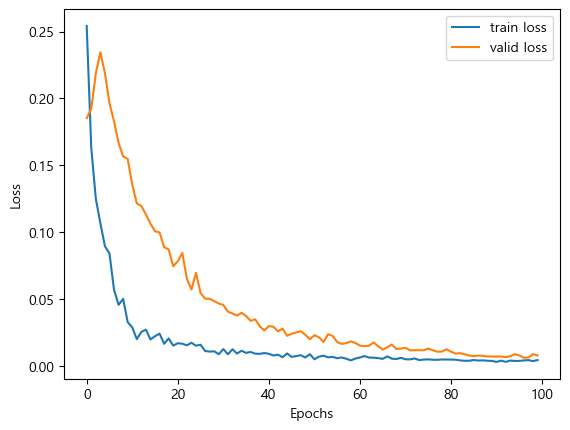

In [54]:
# 손실 시각화
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [58]:
# Rescale the predictions and true values back to the original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 1))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

# Print the predicted and actual values
print("Predicted DFEDTARU values:")
print(y_pred_rescaled)
print("Actual DFEDTARU values:")
print(y_test_rescaled)

Predicted DFEDTARU values:
[0.46172501 0.41456116 0.30208242 0.38379966 0.40002008 0.42599853
 0.25920697 0.22020145 0.33420107 0.53038084 0.79642371 1.38940416
 1.94838583 2.3409379  2.8668527  3.10010748 3.5466537  4.05452435
 4.16036977 4.15548158 4.22011454 4.5718281  4.79506303 4.89816442
 5.03165139 4.97227336 5.11851294 5.15953983 5.08331771 5.13530603
 5.13480379 5.09642424 5.07621934 5.09248202 5.16091701 5.16810019]
Actual DFEDTARU values:
[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.5  0.5  1.   1.75 2.5  2.5
 3.25 3.25 4.   4.5  4.5  4.75 5.   5.   5.25 5.25 5.5  5.5  5.5  5.5
 5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5 ]


In [66]:
# 2024-08-01 예측
last_sequence = scaled_df_irp[-sequence_length:]
future_dates = pd.date_range(start=df_irp_new['DATE'].max(), periods=2, freq='MS')[1:]  # 2024-08-01 예측
predictions = []

for date in future_dates:
    next_pred_scaled = model.predict(last_sequence[np.newaxis, :, :])
    next_pred_rescaled = scaler.inverse_transform(np.concatenate((next_pred_scaled, np.zeros((next_pred_scaled.shape[0], 1))), axis=1))[:, 0]
    predictions.append(next_pred_rescaled[0])
    # 시퀀스를 업데이트하여 다음 예측을 준비
    last_sequence = np.append(last_sequence[1:], [[next_pred_scaled[0][0], np.nan]], axis=0)

# 예측된 미래 데이터프레임 생성
future_df = pd.DataFrame({
    'MODEL':'RNN',
    #'DATE': future_dates,
    'REAL': 5.25,
    'PREDICT': [round(pred, 2) for pred in predictions],
    'DIFF': [round(5.25 - pred, 2) for pred in predictions]
})

# 기존 파일에서 데이터 읽어오기 (파일이 존재하지 않는 경우 예외 처리)
try:
    existing_df = pd.read_csv('./../../result1/result_model_202408.csv')
    combined_df = pd.concat([existing_df, future_df], ignore_index=True)
except FileNotFoundError:
    combined_df = future_df

# 결과를 CSV 파일로 저장
combined_df.to_csv('./../../result1/result_model_202408.csv', index=False)

1/1 [==============================] - 0s 13ms/step
